In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [5]:

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [6]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

# Load Data
Here we will load the data from IU and CU (Piccirillo)

In [8]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,1,hurwitz
1156,1,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,1,hurwitz
1157,0,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,1,hurwitz
1158,1,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,1,hurwitz


In [9]:
# drop all the rows belonging to lab Dipersio
dataset = dataset[dataset['lab'] != 'Dipersio']

In [10]:
dataset.lab.unique()

array(['Piccirillo', 'hurwitz'], dtype=object)

In [ ]:
# dataset = dataset[dataset['lab'] != 'Piccirillo']

In [11]:
dataset.reset_index(drop=True, inplace=True)
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,34,46.80,13.6,40.3,263.0,83.5,3.51000,5.6,7.5,0.8,2.62080,39.07800,0.37440,97.0,1,Piccirillo
1,0,28,57.41,12.7,36.9,325.0,83.8,4.30575,5.9,7.5,0.8,3.38719,48.10958,0.45928,147.0,1,Piccirillo
2,1,51,53.82,14.3,41.2,168.0,88.0,2.31426,4.1,4.3,0.8,2.20662,47.36160,0.43056,183.0,1,Piccirillo
3,0,47,74.42,12.1,36.7,238.0,78.4,5.43266,3.1,7.3,1.9,2.30702,58.34528,1.41398,81.0,1,Piccirillo
4,0,48,55.23,11.9,35.7,295.0,88.5,3.31380,4.1,6.0,0.6,2.26443,48.87855,0.33138,93.0,1,Piccirillo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,1,23,31.30,13.5,39.4,257.0,76.0,2.80000,8.0,9.0,1.0,2.50000,23.80000,0.30000,58.0,1,hurwitz
357,1,56,37.00,15.4,44.9,233.0,77.0,4.40000,7.0,12.0,1.0,2.60000,28.50000,0.40000,59.0,1,hurwitz
358,0,25,51.90,13.8,40.7,265.0,64.0,7.30000,9.0,14.0,1.0,4.70000,33.20000,0.50000,56.0,1,hurwitz
359,1,22,51.00,14.6,42.9,250.0,89.0,4.10000,2.0,8.0,1.0,1.00000,45.30000,0.50000,174.0,1,hurwitz


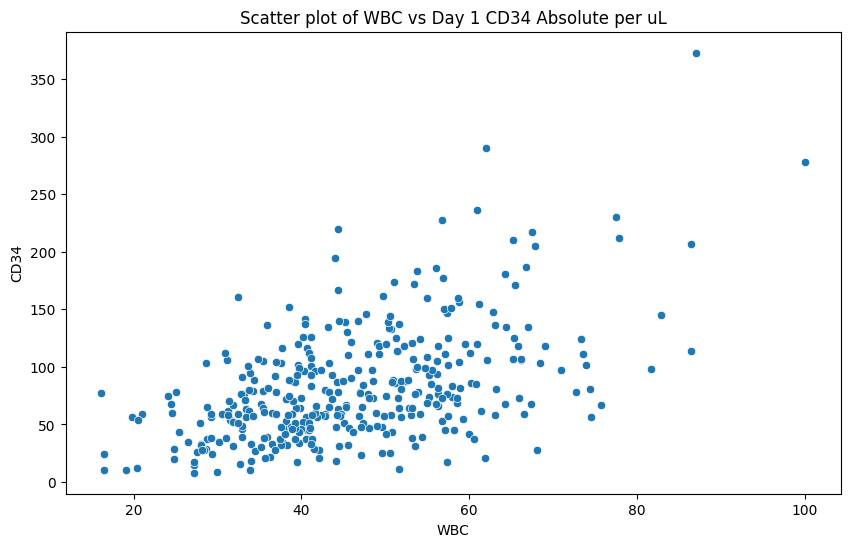

In [12]:
# Plot scatter plot of wbc and Day 1 CD34 Absolute per uL
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='WBC', y='Day 1 CD34 Absolute per uL')
plt.title('Scatter plot of WBC vs Day 1 CD34 Absolute per uL')
plt.xlabel('WBC')
plt.ylabel('CD34')
plt.show()

In [13]:
# Drop columns that are not needed 
cols_to_drop = ['lab', 'Day 1 CD34 Absolute per uL']
dataset = dataset.drop(cols_to_drop, axis=1)
dataset = dataset.dropna()

In [14]:
# remove all rows containing N/A and map samples to respective classes
dataset = dataset.dropna(axis=0, how='any')

In [15]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [16]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [106]:
clf = tbp()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [107]:
# save the model as a pickle file
import pickle
with open(here() / config.model_dl / 'tabpfn_model_iucu.pkl', 'wb') as f:
    pickle.dump(clf, f)

ROC AUC: 0.9926512153759186


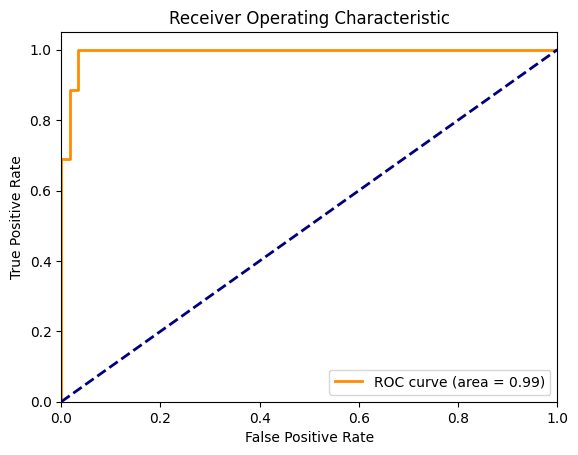

In [108]:
prediction_prob = clf.predict_proba(X_test)
print('ROC AUC:', roc_auc_score(y_test, prediction_prob[:,1]))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_hp' / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_hp' / 'roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

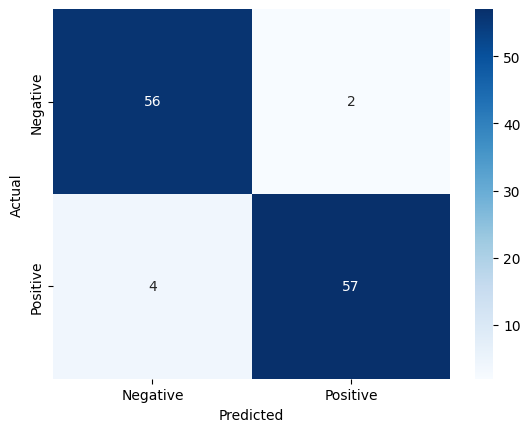

In [109]:
# plot confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_hp' / 'confusion_matrix.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_hp' / 'confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        58
           1       0.97      0.93      0.95        61

    accuracy                           0.95       119
   macro avg       0.95      0.95      0.95       119
weighted avg       0.95      0.95      0.95       119



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')


Accuracy: 0.9496
Precision: 0.9661
Recall: 0.9344
F1 Score: 0.9500
Matthews Correlation Coefficient: 0.8997


In [22]:
# print the prediction probabilities of the first 10 samples
print("Prediction probabilities of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {prediction_prob[i]}")
# print the actual labels of the first 10 samples
print("Actual labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_test[i]}")
# print the predicted labels of the first 10 samples
print("Predicted labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_pred[i]}")


Prediction probabilities of the first 10 samples:
Sample 1: [0.99825615 0.00174385]
Sample 2: [0.3710744 0.6289256]
Sample 3: [0.3512227 0.6487773]
Sample 4: [0.01800095 0.98199904]
Sample 5: [0.99869    0.00131003]
Sample 6: [0.00503662 0.9949634 ]
Sample 7: [0.9109827  0.08901726]
Sample 8: [9.992199e-01 7.801431e-04]
Sample 9: [0.03625276 0.96374726]
Sample 10: [0.02416681 0.9758332 ]
Sample 11: [0.9925427  0.00745735]
Sample 12: [0.0318706 0.9681294]
Sample 13: [9.9967003e-01 3.3001462e-04]
Sample 14: [9.995370e-01 4.630622e-04]
Sample 15: [0.6152228  0.38477725]
Sample 16: [0.11532751 0.8846725 ]
Sample 17: [0.05991265 0.9400873 ]
Sample 18: [0.3992399 0.6007601]
Sample 19: [0.23427227 0.76572776]
Sample 20: [0.13144708 0.8685529 ]
Actual labels of the first 10 samples:
Sample 1: 0
Sample 2: 0
Sample 3: 1
Sample 4: 1
Sample 5: 0
Sample 6: 1
Sample 7: 0
Sample 8: 0
Sample 9: 1
Sample 10: 1
Sample 11: 0
Sample 12: 1
Sample 13: 0
Sample 14: 0
Sample 15: 1
Sample 16: 1
Sample 17: 1
Sa

In [23]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor

In [24]:
# mlp = keras.models.load_model(here() / config.model_dl / 'hpd_auc_91_acc_84_loss_51_gp.keras')

Text(0.5, 1.0, 'Model Comparison - 5-fold Cross-validation')

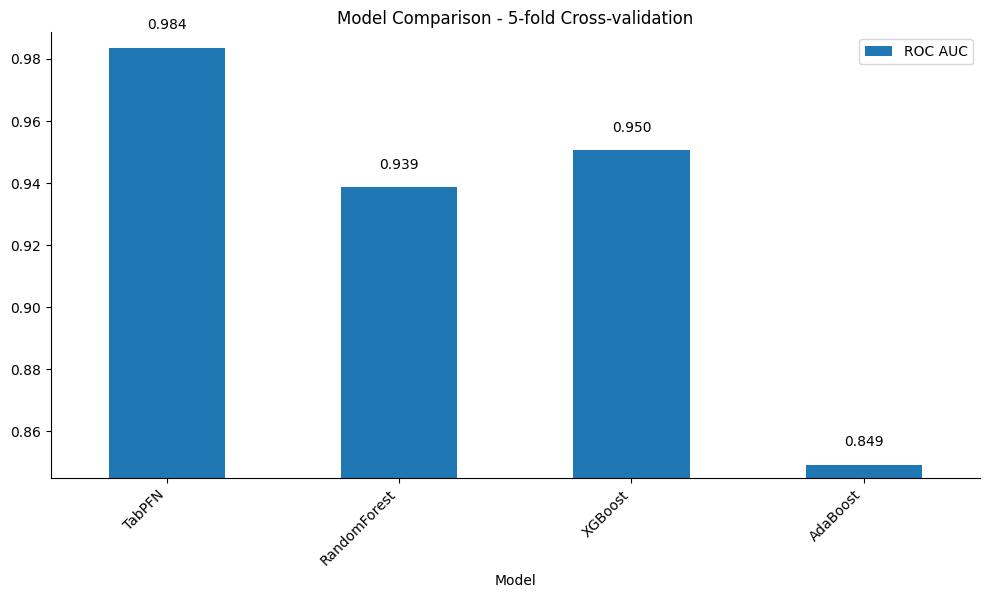

In [25]:
# Define models
models = [
    ('TabPFN', tbp(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    # ('MLP', mlp),
]

# Calculate scores
scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
scores = {name: cross_val_score(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
          for name, model in models}

# Plot results
df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
# plt.grid(axis='y', linestyle='--')
# add numbers on top of the bars
for i, v in enumerate(df['ROC AUC']):
    ax.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.tight_layout()
ax.set_title('Model Comparison - 5-fold Cross-validation')

## Perform Shap Analysis

In [113]:
import shap

In [27]:
print(X_train.shape, X_test.shape)

(473, 14) (119, 14)


PermutationExplainer explainer: 120it [21:44:04, 657.52s/it]                           


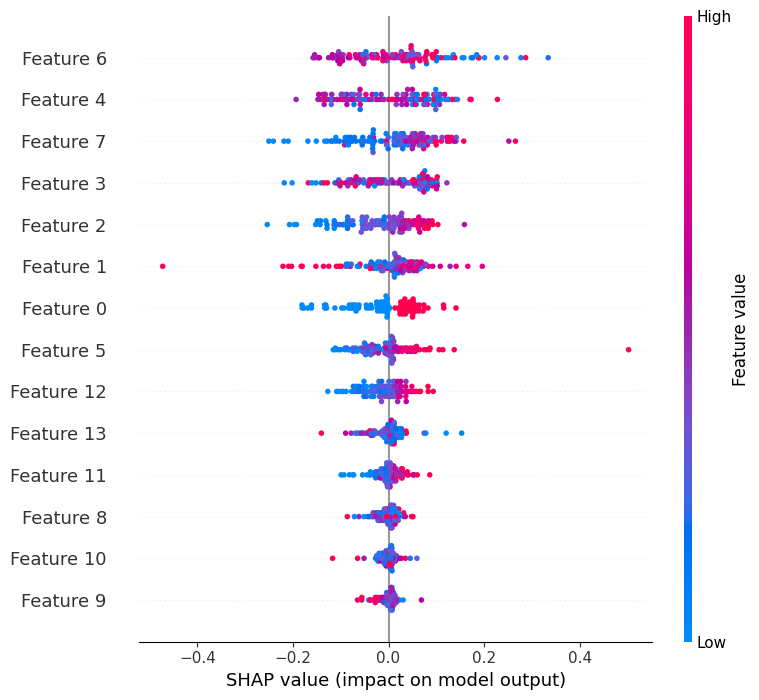

In [28]:
explainer = shap.Explainer(clf.predict, X_train) # Raises TypeError
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [34]:
X

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs
0,1.0,0.415584,0.365476,0.642105,0.680556,0.486792,0.792812,0.205303,0.121053,0.211538,0.133333,0.249548,0.440172,0.124800
1,0.0,0.337662,0.491786,0.547368,0.562500,0.603774,0.799154,0.265587,0.128947,0.211538,0.133333,0.331956,0.561827,0.153093
2,1.0,0.636364,0.449048,0.715789,0.711806,0.307547,0.887949,0.114717,0.081579,0.088462,0.133333,0.205013,0.551752,0.143520
3,0.0,0.584416,0.694286,0.484211,0.555556,0.439623,0.684989,0.350959,0.055263,0.203846,0.316667,0.215809,0.699702,0.471327
4,0.0,0.597403,0.465833,0.463158,0.520833,0.547170,0.898520,0.190439,0.081579,0.153846,0.100000,0.211229,0.572185,0.110460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,1.0,0.488743,0.322484,0.803677,0.825949,0.500956,0.503707,0.301575,0.102850,0.349681,0.484716,0.194440,0.318550,0.411936
588,1.0,0.374597,0.169194,0.734429,0.789448,0.344464,0.776894,0.160338,0.099557,0.293790,0.136545,0.127050,0.252574,0.074227
589,0.0,0.287109,0.150725,0.672554,0.705665,0.355451,0.801112,0.124214,0.117008,0.221866,0.166667,0.132497,0.238416,0.103580
590,0.0,0.582763,0.271977,0.609187,0.667557,0.346443,0.788049,0.161249,0.108789,0.211699,0.192909,0.183836,0.350161,0.149005


In [35]:
# Save the SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_values_df.to_csv(here() / config.data_interim / 'shap_values_iucu_tabpfn.csv', index=False)

In [111]:
shap_values_df = pd.read_csv(here() / config.data_interim / 'shap_values_iucu_tabpfn.csv')
shap_values_df.head()

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs
0,0.073824,0.001176,-0.035882,-0.030882,-0.147647,-0.035588,-0.157941,-0.078235,-0.015000,0.008529,-0.005294,-0.027941,-0.035882,-0.013235
1,0.030588,0.021765,0.040882,0.064706,0.054412,0.046176,0.132647,0.063235,0.004706,0.005000,0.005000,0.009706,0.012353,0.008824
2,-0.011176,0.067059,-0.055588,0.101765,0.098824,0.007059,0.277059,0.015588,0.009118,0.002941,0.016765,-0.005882,-0.046471,0.022941
3,0.036176,0.057941,0.071765,0.090000,0.094706,0.008529,0.046471,0.011765,0.002059,0.007647,0.004706,0.005588,0.035588,0.027059
4,-0.062647,0.002941,-0.090588,-0.201765,0.080882,-0.021176,-0.104412,0.045588,-0.018235,-0.056176,-0.004412,-0.037941,-0.043235,0.011176


In [114]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10, show=False)
f = plt.gcf()
f.set_size_inches(10, 6)
plt.tight_layout()

sns.despine()
# plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
# plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'shap_summary_plot.pdf', dpi=300, bbox_inches='tight')


NameError: name 'shap_values' is not defined

In [ ]:
shap.initjs()

In [101]:
# shap.force_plot(shap_values, X_test)

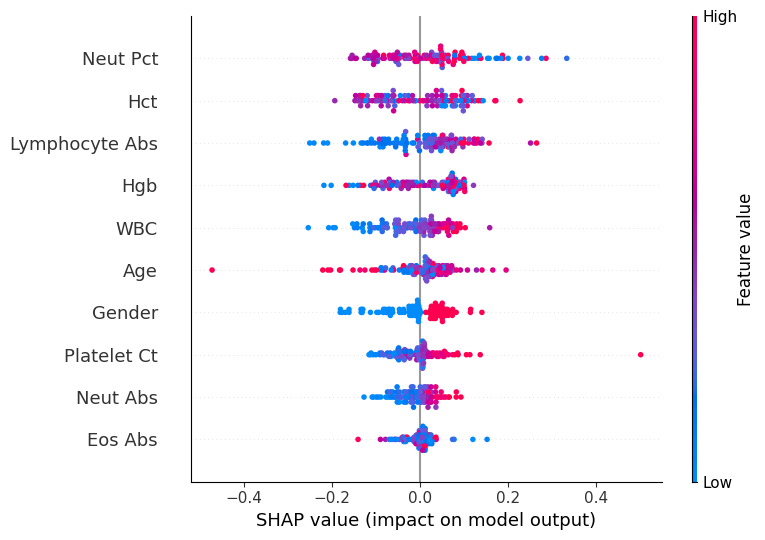

In [118]:
shap.summary_plot(shap_values, X_test, show=False, max_display=10)

sns.despine()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'shap_beeswarm.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_domain_all' / 'shap_beeswarm.pdf', dpi=500, bbox_inches='tight')


In [53]:
# save shap values array 
shap_values_array = shap_values.values
np.save(here() / config.data_interim / 'shap_values_iucu_tabpfn.npy', shap_values_array)

In [103]:
# read the shapvalues froma file
shaplyvals = np.load(here() / config.data_interim / 'shap_values_iucu_tabpfn.npy')

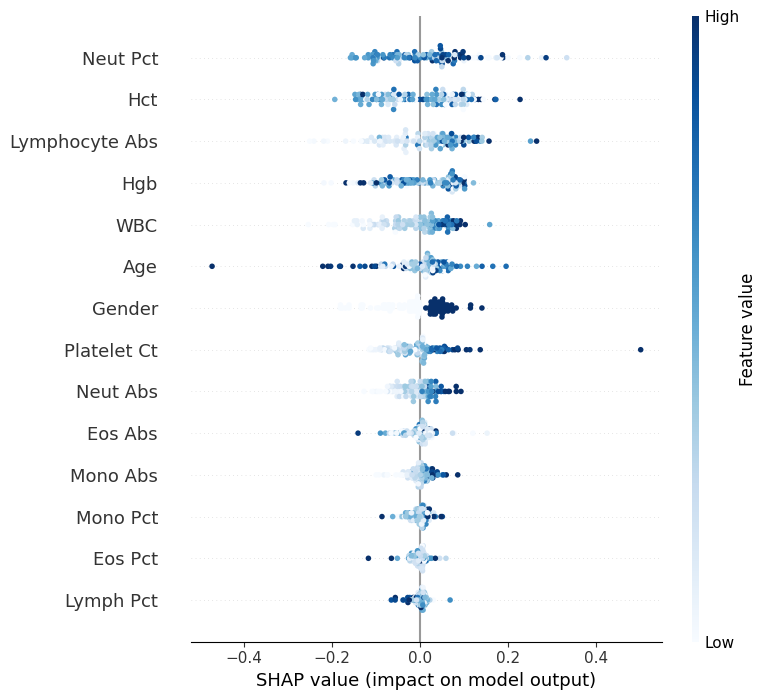

In [108]:
shap.summary_plot(shap_values, X_test, cmap="Blues")

In [120]:
# instead of np.array([...]) do:
out = here() / config.data_interim / 'shap_values_iucu_tabpfn_all.npz'
np.savez(
    out,
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data
)
print("saved to", out)

saved to c:\workspace_dl\data\interim\shap_values_iucu_tabpfn_all.npz


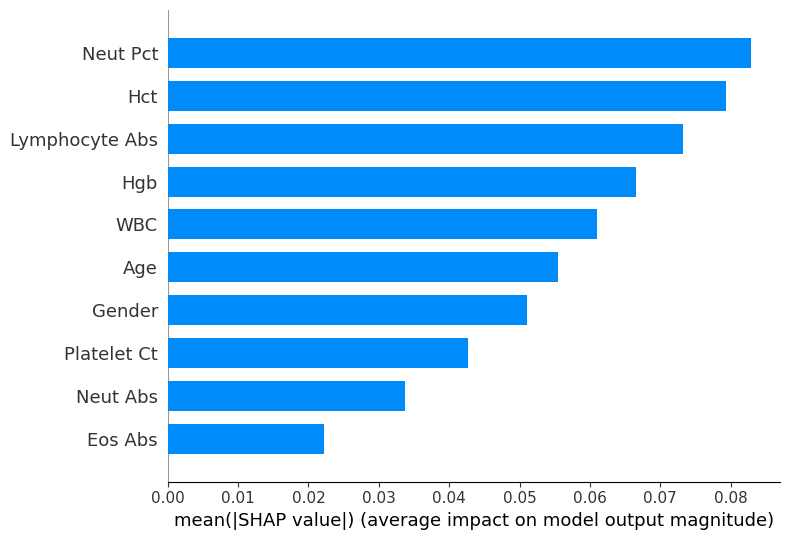

In [116]:

data = np.load(here() / config.data_interim / 'shap_values_iucu_tabpfn_all.npz')

shap_values_restored = shap.Explanation(
    values     = data['values'],      # (n_samples, n_features)
    base_values= data['base_values'], # (n_samples,) or (n_outputs, )
    data       = data['data'],        # the original X_test array
    feature_names = X.columns.tolist()
)

shap.summary_plot(shap_values_restored, X_test, plot_type="bar", max_display=10, show=False)